## Se prueba la optimización random (y se analizan versiones cambiando la cantidad de paredes)

Usamos la sala de prueba 1

In [1]:
import os
import time
os.chdir('..')

In [2]:
from room.geometry_generator import calculation_of_geometry
from mesh.mesh_3D_complex import create_complex_mesh
from FEM.FEM_source import FEM_Source_Solver_Average
from aux.merit_figure import merit_magnitude_deviation, merit_spatial_deviation
from plots.graph_room_outline import plot_room_outline

import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Definimos el cuarto
Lx = 250       # Largo de la sala en X 
Ly = 300       # Largo de la sala en Y
Lz = 220       # Alto de la sala
Dx = 50        # Delta X
Dy = 80        # Delta Y
Dz = 10        # Delta Z

# Posiciones fuente y receptor (en metros)
source_position = (1.9, 1.0, 1.3)
receptor_position = (1.25, 1.9, 1.2)

El resultado con 2 paredes es el base

In [17]:
# Parametros de control
N = 250        # Densidad de la grilla del generador de geometrías
M = 200        # Cantidad de salas a generar
n_walls = 5    # Número de cortes en las paredes
res_freq = 1

In [18]:
# Almacenar toda la data
start_time = time.time()
rooms = calculation_of_geometry(Lx, Ly, Dx, Dy, N, M, n_walls)
mesh = "room_mesh_complex"  # Crear malla con el script correspondiente
mesh1 = "room_mesh_complex1"  # Crear malla con el script correspondiente
mesh2 = "room_mesh_complex2"  # Crear malla con el script correspondiente
mesh3 = "room_mesh_complex3"  # Crear malla con el script correspondiente
mag_responses = []
merit_sv_values = []
merit_md_values = []

# Itera y almacena los valores para encontrar el mejor cuarto
for i in range(M):
    print("Vamos por el room: ", i)

    # Crea la malla de la geometría selecionada
    Z = (Lz - np.random.uniform(0, Dz))/100
    create_complex_mesh(rooms[i], Z, source_position, 80, mesh1)
    create_complex_mesh(rooms[i], Z, source_position, 140, mesh2)
    create_complex_mesh(rooms[i], Z, source_position, 200, mesh3)

    # Evalua la rta en frecuencia para esa sala
    f1 = np.arange(20, 80, res_freq)
    res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

    f2 = np.arange(80, 140, res_freq)
    res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

    f3 = np.arange(140, 200, res_freq)
    res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

    res_tot = np.hstack([res1, res2, res3])
    res_tot_prom = np.sum(res_tot, axis=0) / 7

    # Calcula figuras de mérito
    sv_merit = merit_spatial_deviation(res_tot)
    md_merit = merit_magnitude_deviation(res_tot)
    
    merit_sv_values.append(sv_merit)
    merit_md_values.append(md_merit)
    mag_responses.append(res_tot_prom)

f_tot =  np.hstack([f1, f2, f3])
merit_sv_values = np.array(merit_sv_values)
merit_md_values = np.array(merit_md_values)
merit_general = merit_md_values + merit_sv_values

idx_best_room = np.argmin(merit_general)
idx_worst_room = np.argmax(merit_general)

best_room_mag = mag_responses[idx_best_room]
worst_room_mag = mag_responses[idx_worst_room]
random_room_mag = mag_responses[np.random.randint(0, M - 1)]


Vamos por el room:  0
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 98 entities
Info    : 674 nodes
Info    : 3611 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 93 entities
Info    : 1339 nodes
Info    : 7299 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 93 entities
Info    : 3873 nodes
Info    : 22597 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Vamos por el room:  1
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 93 entities
Info    : 430 nodes
Info    : 2173 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 93 entities
Info    : 1395 nodes
Info    : 7565 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 93 entit

Resultado con n_walls = 3

In [6]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 13.715423639330094 | Con SV: 3.1249662688960003 | Con MD: 10.590457370434093
............................
El peor valor de mérito es: 20.677760138404317 | Con SV: 4.134193109037221 | Con MD: 16.543567029367097
............................
El valor de mértio promedio es:  17.011879813856464
............................
El tiempo de ejecución en minutos fue de:  51.12027179400126


In [8]:
from complex_outline_optim import calculate_initial

merit_0, mag0 = calculate_initial(Lx/100, Ly/100, Lz/100, source_position, receptor_position)
freq_base = np.arange(20, 200, 1)
merit_0

Info    : Reading 'mallado/room_base_optim1.msh'...
Info    : 33 entities
Info    : 705 nodes
Info    : 3928 elements
Info    : Done reading 'mallado/room_base_optim1.msh'
Info    : Reading 'mallado/room_base_optim2.msh'...
Info    : 33 entities
Info    : 1858 nodes
Info    : 10518 elements
Info    : Done reading 'mallado/room_base_optim2.msh'
Info    : Reading 'mallado/room_base_optim3.msh'...
Info    : 33 entities
Info    : 6201 nodes
Info    : 36807 elements
Info    : Done reading 'mallado/room_base_optim3.msh'


(15.935706884213301, 12.540030814890079, 3.3956760693232226)

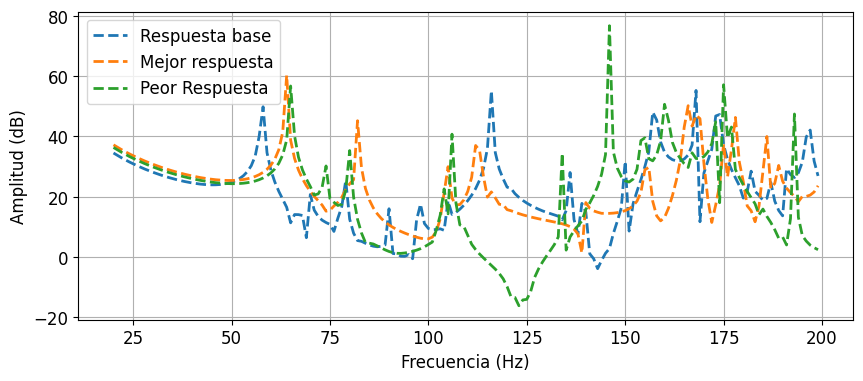

In [9]:
from plots.graph_mag_response import mag_response_comparison

freqs_res1 = np.arange(20, 200, 1)
mags = [(freqs_res1, mag0, "Respuesta base"), (f_tot, best_room_mag, "Mejor respuesta"), (f_tot, worst_room_mag, "Peor Respuesta")]
mag_response_comparison(mags)

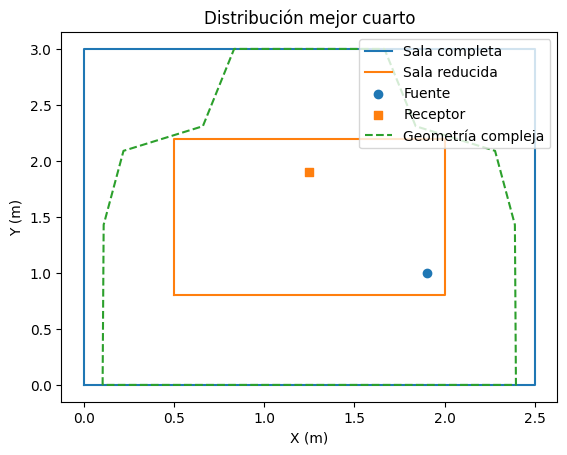

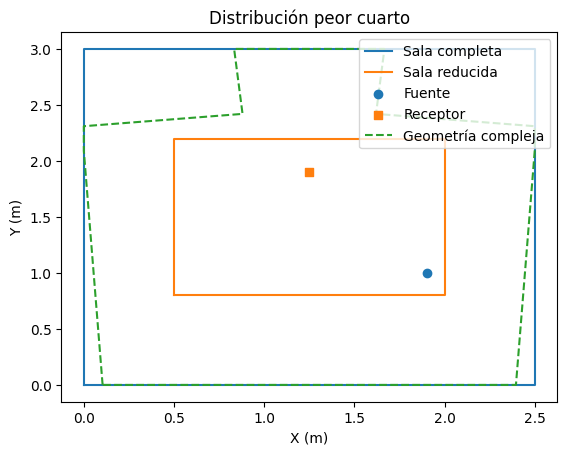

La mejor sala es:  [[0.10416667 0.        ]
 [0.11       1.43      ]
 [0.22       2.09      ]
 [0.66       2.31      ]
 [0.83333333 3.        ]
 [1.66666667 3.        ]
 [1.84       2.31      ]
 [2.28       2.09      ]
 [2.39       1.43      ]
 [2.39583333 0.        ]]
............................
La peor sala es:  [[0.10416667 0.        ]
 [0.         2.09      ]
 [0.         2.31      ]
 [0.88       2.42      ]
 [0.83333333 3.        ]
 [1.66666667 3.        ]
 [1.62       2.42      ]
 [2.5        2.31      ]
 [2.5        2.09      ]
 [2.39583333 0.        ]]


In [7]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])

Respuesta con n_walls = 4

In [15]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 12.907270242834125 | Con SV: 2.9519888643292194 | Con MD: 9.955281378504905
............................
El peor valor de mérito es: 21.067436168243525 | Con SV: 5.283472418558804 | Con MD: 15.78396374968472
............................
El valor de mértio promedio es:  16.362195357475866
............................
El tiempo de ejecución en minutos fue de:  54.15094521840413


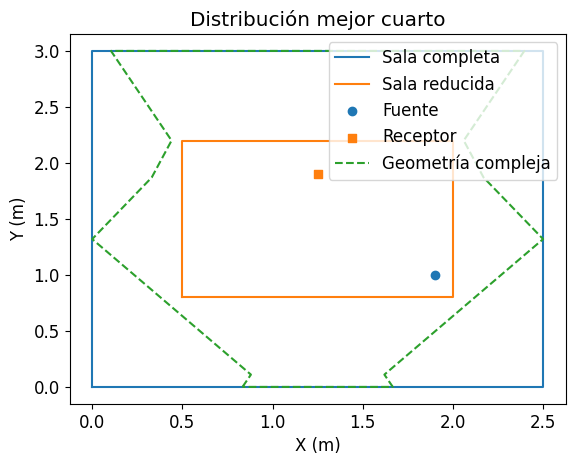

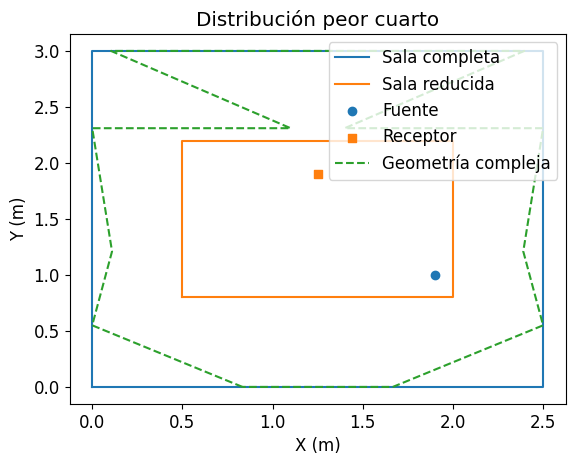

La mejor sala es:  [[0.83333333 0.        ]
 [0.88       0.11      ]
 [0.         1.32      ]
 [0.33       1.87      ]
 [0.44       2.2       ]
 [0.10416667 3.        ]
 [2.39583333 3.        ]
 [2.06       2.2       ]
 [2.17       1.87      ]
 [2.5        1.32      ]
 [1.62       0.11      ]
 [1.66666667 0.        ]]
............................
La peor sala es:  [[0.83333333 0.        ]
 [0.         0.55      ]
 [0.11       1.21      ]
 [0.         2.31      ]
 [1.1        2.31      ]
 [0.10416667 3.        ]
 [2.39583333 3.        ]
 [1.4        2.31      ]
 [2.5        2.31      ]
 [2.39       1.21      ]
 [2.5        0.55      ]
 [1.66666667 0.        ]]


In [16]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])

n_walls = 5

In [19]:
print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))
print("............................")
print("El tiempo de ejecución en minutos fue de: ", (time.time() - start_time)/60)

El valor de mértio mínimo es: 13.052205191668204 | Con SV: 3.469422024681843 | Con MD: 9.58278316698636
............................
El peor valor de mérito es: 21.826403210583884 | Con SV: 5.720804738998817 | Con MD: 16.105598471585065
............................
El valor de mértio promedio es:  17.58863149470271
............................
El tiempo de ejecución en minutos fue de:  60.54233276049296


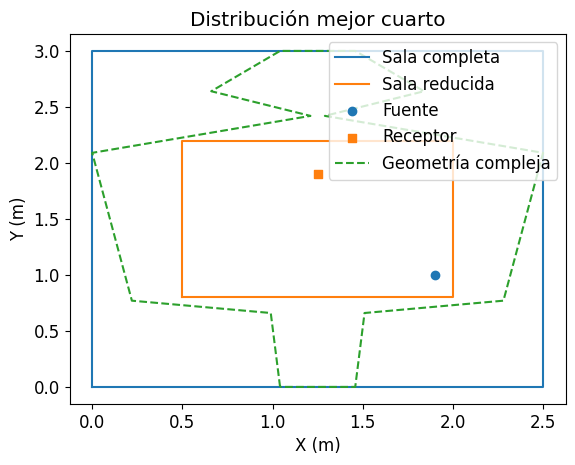

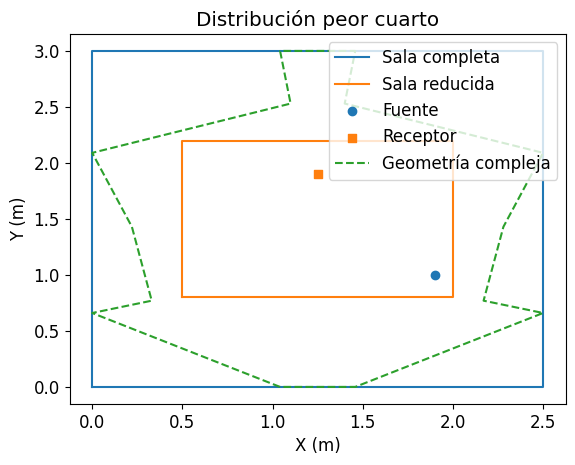

La mejor sala es:  [[1.04166667 0.        ]
 [0.99       0.66      ]
 [0.22       0.77      ]
 [0.         2.09      ]
 [1.21       2.42      ]
 [0.66       2.64      ]
 [1.04166667 3.        ]
 [1.45833333 3.        ]
 [1.84       2.64      ]
 [1.29       2.42      ]
 [2.5        2.09      ]
 [2.28       0.77      ]
 [1.51       0.66      ]
 [1.45833333 0.        ]]
............................
La peor sala es:  [[1.04166667 0.        ]
 [0.         0.66      ]
 [0.33       0.77      ]
 [0.22       1.43      ]
 [0.         2.09      ]
 [1.1        2.53      ]
 [1.04166667 3.        ]
 [1.45833333 3.        ]
 [1.4        2.53      ]
 [2.5        2.09      ]
 [2.28       1.43      ]
 [2.17       0.77      ]
 [2.5        0.66      ]
 [1.45833333 0.        ]]


In [20]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_best_room], "Distribución mejor cuarto")
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

print("La mejor sala es: ", rooms[idx_best_room])
print("............................")
print("La peor sala es: ", rooms[idx_worst_room])